In [133]:
# Open Gym Environment
import gym
import gym_mppt

# # Check Gym Environments
# from gym import envs
# all_envs = envs.registry
# for key, value in sorted(all_envs.items(), key=lambda x: x[0]): 
#     print(key)

In [134]:
problem = 'mppt_shaded-v1'
env = gym.make(problem)

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  15.0
Min Value of Action ->  -15.0


iteration 0
[1829 2073 2555]
[91.44999999999695, 103.64999999999625, 127.74999999999488]
[30787.034920521997, 27894.853545711416, 19515.045511204615]


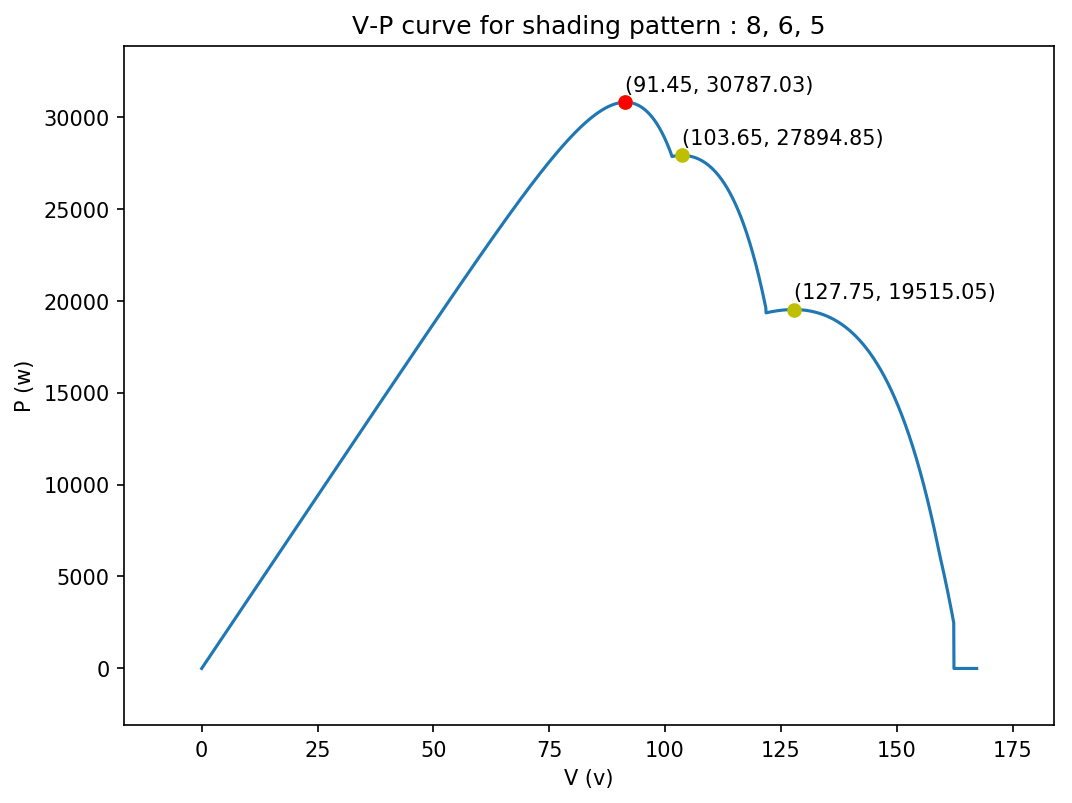

iteration 1
[1477 1734 2931 3222]
[73.84999999999795, 86.69999999999722, 146.54999999999907, 161.10000000000238]
[24908.238168717424, 23404.687578821053, 21418.772310551478, 20463.761425090353]


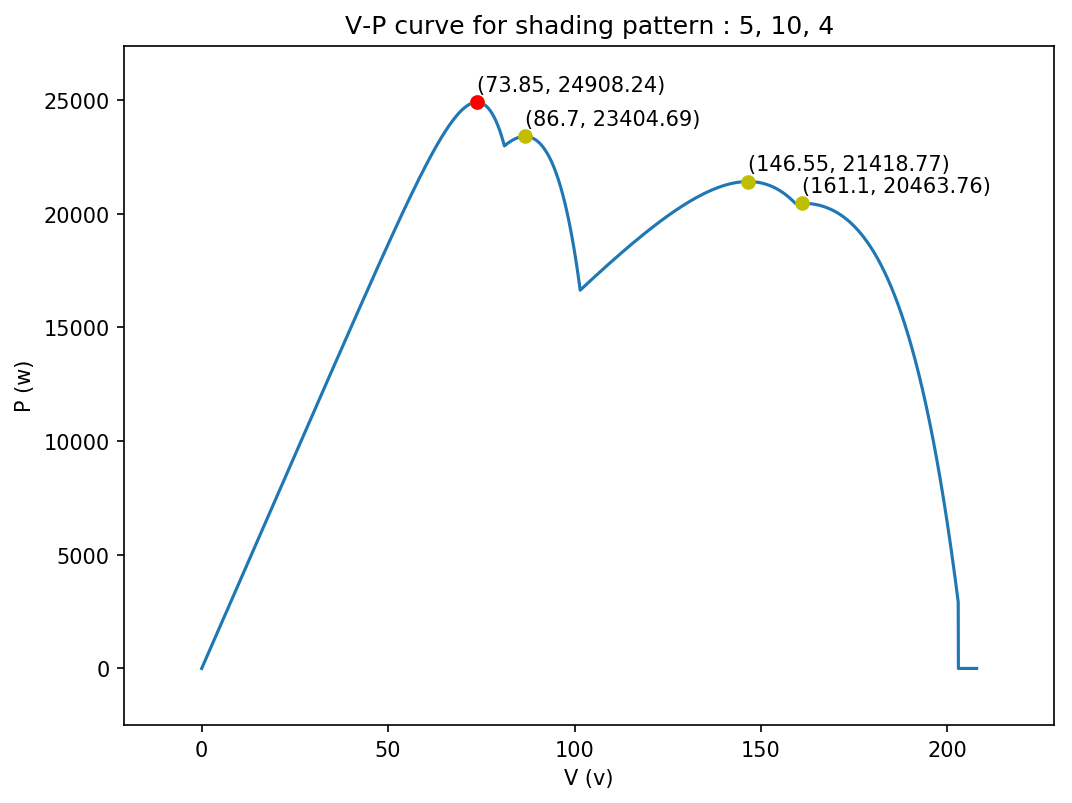

iteration 2
[ 710 2483 2931 3222]
[35.50000000000012, 124.14999999999509, 146.54999999999907, 161.10000000000238]
[11992.048536983802, 26663.07076869269, 21418.772310551478, 20463.761425090353]


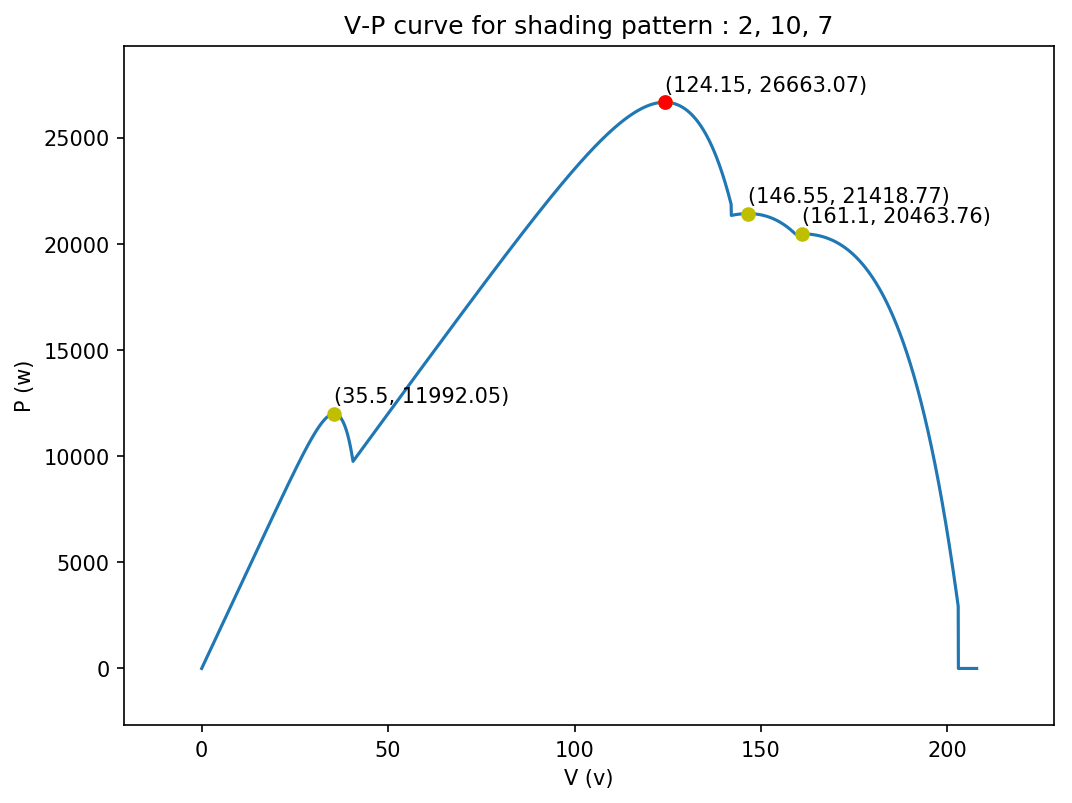

iteration 3
[1071 2151 2788]
[53.549999999999095, 107.54999999999603, 139.39999999999745]
[18076.392694127688, 23810.31991035923, 21240.69123217497]


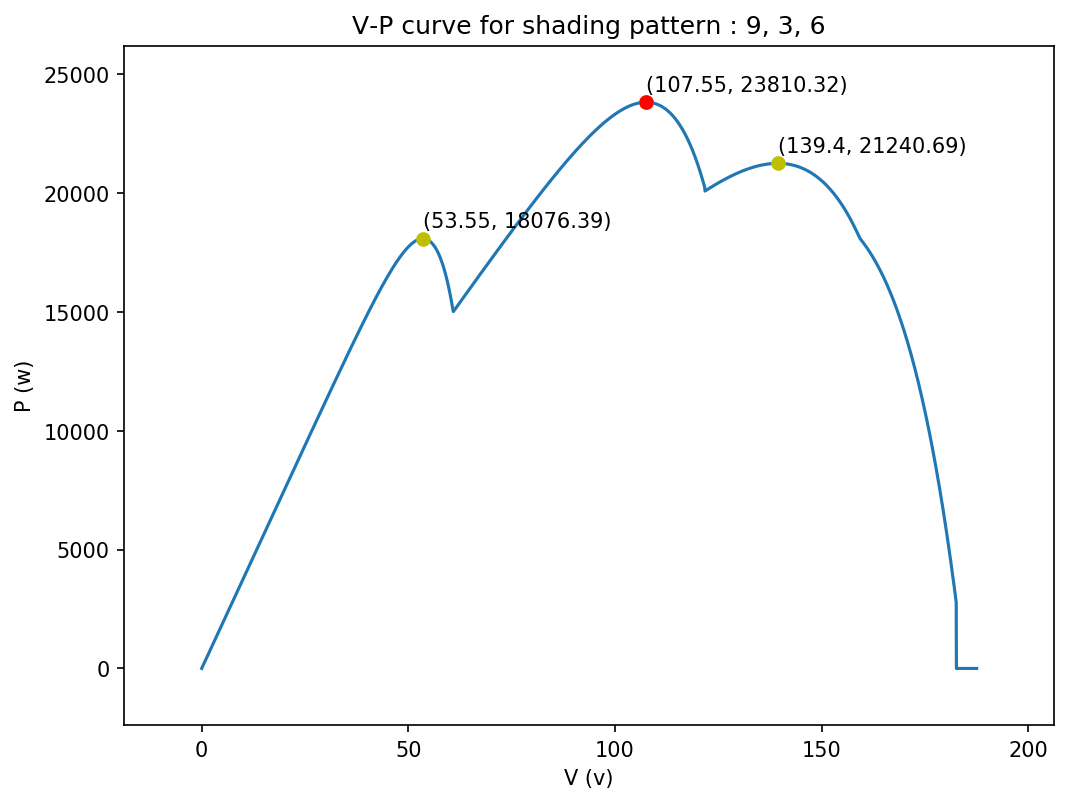

iteration 4
[1773 2905]
[88.6499999999971, 145.24999999999878]
[29904.8390206548, 30926.241096814425]


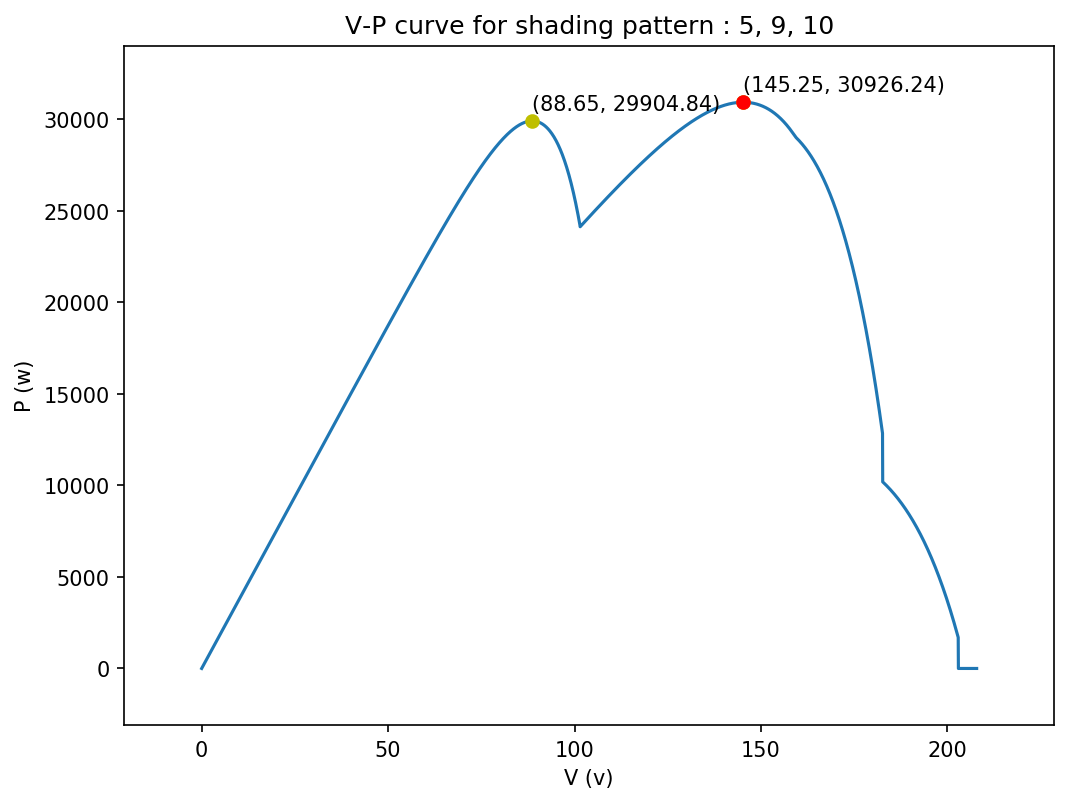

iteration 5
[1064 1795 2553]
[53.199999999999115, 89.74999999999704, 127.64999999999489]
[17953.355372358434, 19353.994311265855, 18730.114219554893]


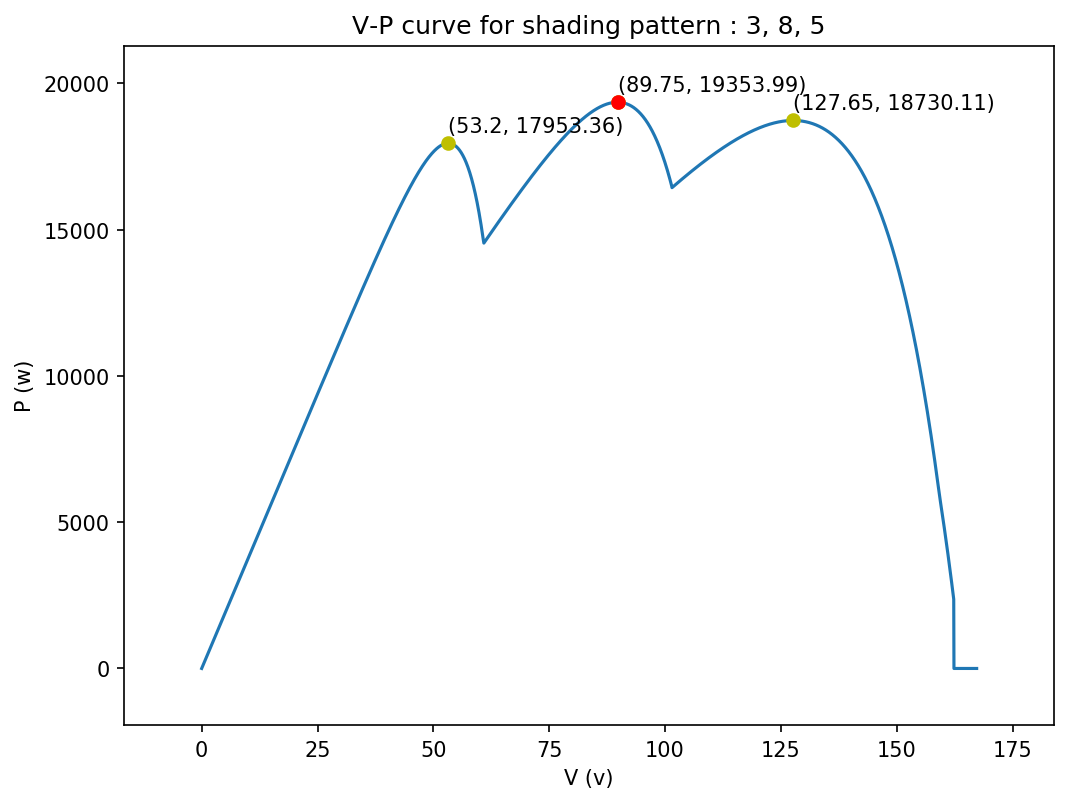

iteration 6
[ 355  721 1636 2408]
[17.750000000000117, 36.05000000000009, 81.7999999999975, 120.3999999999953]
[5992.423443415275, 7799.301263849332, 12085.182559820738, 3882.015182130481]


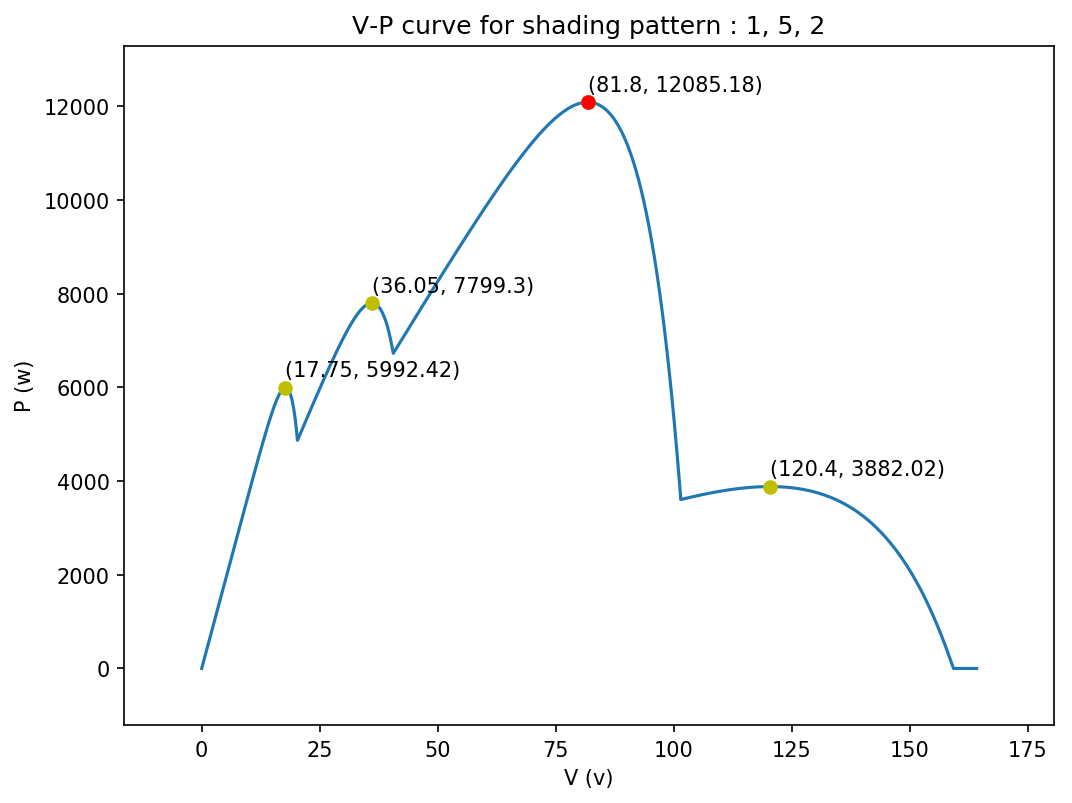

iteration 7
[1419 2364 3222]
[70.94999999999811, 118.19999999999543, 161.10000000000238]
[23926.542986786997, 25321.874255218172, 11847.44082505231]


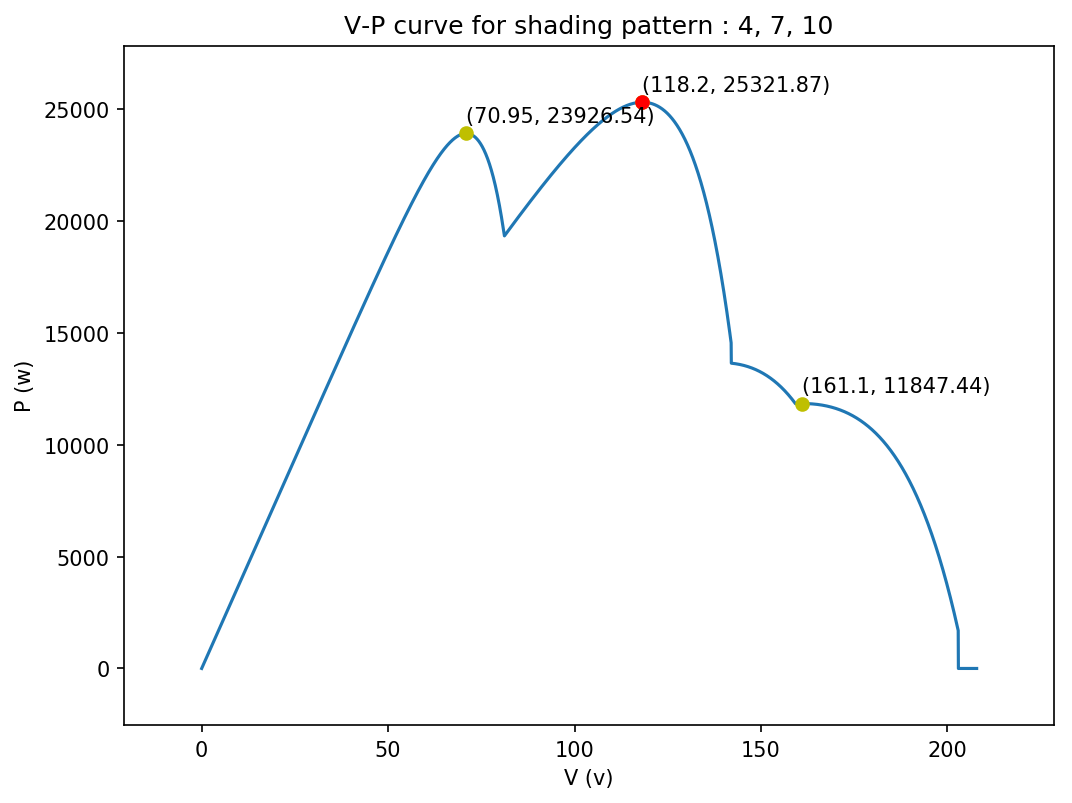

In [136]:
%run Graphs2.ipynb
import warnings
warnings.filterwarnings('ignore')
from scipy.signal import find_peaks

observation = env.reset()
# print(observation)

irradiances = list([1000.]) * 8
temperatures = list([25.]) * 8
# [a, 10, b, 10, c, 10]
sh = list([[8, 10, 6, 10, 5, 10],       # Fig 9      (8, 6 and 5)
           [5, 10, 10, 10, 4, 10],      # Fig 11     (5, 10 and 4)
           [2, 10, 10, 10, 7, 10],      # Fig 13 (c) (2, 10 and 7)
           [9, 10, 3, 10, 6, 10],       #            (9, 3 and 6)
           [5, 10, 9, 10, 10, 10],      #            (5, 9 and 10)
           [3, 10, 8, 10, 5, 10],       # Fig 14 (c) (3, 8 and 5)
           [1, 10, 5, 10, 2, 10],       #            (1, 5 and 2)
           [4, 10, 7, 10, 10, 10]       #            (4, 7 and 10)
          ])

max_steps = 6000
# min_action = -5.
# max_action = 5.

observation = env.setTempIrr(observation, temperatures[0], irradiances[0], sh[0])
# data = DATA(observation, temperatures[0], irradiances[0])
data = [0] * len(temperatures)

for i in range(len(temperatures)):
    #observation =  env.reset()
    observation = env.reset()
    env.setTempIrr(observation, temperatures[i], irradiances[i], sh[i])
    data[i] = DATA(observation, temperatures[i], irradiances[i])
   
    for j in range(max_steps):
#         tf_observation = tf.expand_dims(tf.convert_to_tensor(observation), 0)    
        action = 0.05
#         action = policy(tf_observation, ou_noise)
#         action = np.clip(action,min_action,max_action)
#         print(action)

        observation, reward, done, info = env.step(action)
        data[i].add(observation[0], observation[1], observation[2], info['Corriente'], info['Temperatura'], info['Irradiancia'], info['Accion'])

########### Plotting ###########

    print('iteration', i)
    
####     Stripping zeroes from the end
    stripidx = 0
    for stripidxitr in range(len(data[i].P) - 1, -1, -1): 
        if data[i].P[stripidxitr] > 0.0:
            stripidx = stripidxitr
            break

####     Finding Peaks
    peaks, _ = find_peaks(data[i].P, prominence=1)    
    print(peaks)
    Vpeaks = []
    Ppeaks = []
    Pmax = -1
    Pmaxidx = 0
    for peak in range(len(peaks)):
        Vpeaks.append(data[i].V[peaks[peak]])
        Ppeaks.append(data[i].P[peaks[peak]])
        if data[i].P[peaks[peak]] > Pmax:
            Pmax = data[i].P[peaks[peak]]
            Pmaxidx = peak
    print(Vpeaks)
    print(Ppeaks)
    RoundVpeaks = [round(num, 2) for num in Vpeaks]
    RoundPpeaks = [round(num, 2) for num in Ppeaks]

####     Plotting Graph
#     data[i].plotear()
    figure(figsize=(8, 6), dpi=150)
    plt.plot(data[i].V[:stripidx + 100], data[i].P[:stripidx + 100])
    plt.plot(RoundVpeaks, RoundPpeaks, "oy")
    plt.plot(RoundVpeaks[Pmaxidx], RoundPpeaks[Pmaxidx], "or")
    plt.xlabel('V (v)')
    plt.ylabel('P (w)')
    plt.title('V-P curve for shading pattern : '+ str(sh[i][0]) + ", " + str(sh[i][2]) + ", " + str(sh[i][4]))
    for i_x, i_y in zip(RoundVpeaks, RoundPpeaks):
        plt.text(i_x, i_y + RoundPpeaks[Pmaxidx] / 50, '({}, {})'.format(i_x, i_y))
    plt.margins(x=0.1, y=0.1)
    plt.show()
    
# print(data)